# INSTALL LIBRARIES

In [1]:
!pip install transformers torch tensorflow scikit-learn requests -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.1 MB/s eta 0:00:00


## IMPORT LIBRARIES

In [18]:
import pandas as pd
import numpy as np
import re
from google.colab import drive
import os

from sklearn.model_selection import train_test_split

# ploting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# warnings
import warnings
warnings.filterwarnings('ignore')

# FETCH DATASET

- As we are working on google colab which has temp file storage i prefer to use google drive to access the dataset

In [19]:
# Mount Drive
drive.mount("/content/drive")

# after mount you will see the drive from there you can get the dataset path
dataset_path = "/content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION"

# load the dataset using pandas

train_df= pd.read_csv(os.path.join(dataset_path,'Train_data.csv'))
test_df = pd.read_csv(os.path.join(dataset_path, 'Test_data.csv'))

print(f"Train Dataset : {train_df.shape}")
print(f"Test Dataset : {test_df.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train Dataset : (160682, 7)
Test Dataset : (40171, 6)


# GENERAL DATA PREPROCESSING

In [ ]:
test_df.isnull().sum()

REF_NO                  0
headline                0
authors                 0
link                    0
short_description    3915
date                    0
dtype: int64

In [20]:
import re

def clean_text(txt):
    txt = txt.lower()
    # Remove web links (http, https, www, etc.)
    txt = re.sub(r'http\S+|www\S+|https\S+', '', txt, flags=re.MULTILINE)

    # Remove email addresses
    txt = re.sub(r'\S*@\S*\s?', '', txt)

    # Remove special characters (keeping only alphanumeric characters and spaces)
    txt = re.sub(r'[^a-zA-Z0-9\s]', '', txt)

    # Remove numbers
    txt = re.sub(r'\d+', '', txt)

    # Remove extra spaces
    txt = re.sub(r'\s+', ' ', txt).strip()





    return txt

In [21]:
def data_cleaning(df):
  print(f"Before DataSet Null counts \n {df.isnull().sum()}")
  df['short_description']= df['short_description'].fillna(df['headline'])
  df.dropna(inplace=True)
  print(f"After DataSet Null counts \n {df.isnull().sum()}")
  print("Cleaning the Text ")
  df['short_description']=df['short_description'].apply(clean_text)
  print("Cleaning process is completed Successfully  ")
  return df

In [22]:
train_clean_df= data_cleaning(train_df)
test_clean_df = data_cleaning(test_df)

Before DataSet Null counts 
 REF_NO                   0
headline                 6
authors                  0
link                     0
short_description    15797
date                     0
category                 0
dtype: int64
After DataSet Null counts 
 REF_NO               0
headline             0
authors              0
link                 0
short_description    0
date                 0
category             0
dtype: int64
Cleaning the Text 
Cleaning process is completed Successfully  
Before DataSet Null counts 
 REF_NO                  0
headline                0
authors                 0
link                    0
short_description    3915
date                    0
dtype: int64
After DataSet Null counts 
 REF_NO               0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64
Cleaning the Text 
Cleaning process is completed Successfully  


In [ ]:
train_clean_df.head(3)

,REF_NO,headline,authors,link,short_description,date,category
0,123291,"Putin, Fear and Leadership","James A. Cusumano, Ph.D., ContributorOwner and...",https://www.huffingtonpost.com/entry/the-simil...,there are uncomfortable parallels between hitl...,2014-05-08,POLITICS
1,37541,"Barack Obama Failed To Get A New Climate Law, ...",Kate Sheppard,https://www.huffingtonpost.com/entry/barack-ob...,the fate of climate rules now lies with the su...,2017-01-11,POLITICS
2,84614,Senate GOP Leaders Want To Put Ted Cruz In A T...,Laura Barrón-López,https://www.huffingtonpost.com/entry/senate-go...,washington senate republican leaders spent a r...,2015-07-26,POLITICS


In [ ]:
train_clean_df['short_description'][6]

'i spent most of my s obsessing about love when will i meet him when will i find true love why isnt he calling me why am i alone where is he who is he am i over him why cant i get over him these were the litany of questions that lived in my mind every day'

In [23]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def lemmatize_text(txt):
  words = txt.split()
  lemmatized_words=[lemmatizer.lemmatize(word) for word in words if word not in stop_words]

  return ' '.join(lemmatized_words)


In [25]:
train_clean_df['lemmatize'] = train_clean_df['short_description'].apply(lemmatize_text)
test_clean_df['lemmatize'] = test_clean_df['short_description'].apply(lemmatize_text)

# Tokenization and Padding

In [26]:
from transformers import DistilBertTokenizer


# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_text(txt):
  tokens = tokenizer.encode_plus(
      txt,
      max_length =128,
      truncation  = True,
      padding ='max_length',
      add_special_tokens='True',
      return_tensors = 'tf'


  )
  return tokens['input_ids'], tokens['attention_mask']



In [27]:
df = pd.DataFrame()
df['input_ids'], df['attention_mask'] =  zip(*train_clean_df['lemmatize'].apply(tokenize_text))

test=pd.DataFrame()
test['input_ids'], test['attention_mask'] =  zip(*test_clean_df['lemmatize'].apply(tokenize_text))


# Target Columns Encode

In [29]:
# Label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_clean_df['encoded_category'] = label_encoder.fit_transform(train_clean_df['category'])

# y = train_clean_df['encoded_category']

# labels = tf.constant(train_clean_df['encoded_category'] .values)

In [ ]:
num_categories=len(train_clean_df['category'].unique())

In [41]:
import tensorflow as tf

# Convert to tensors
input_ids = tf.constant([tf.squeeze(i, axis=0).numpy() for i in df['input_ids']])
attention_mask = tf.constant([tf.squeeze(i, axis=0).numpy() for i in df['attention_mask']])
labels = tf.constant(train_clean_df['encoded_category'].values)

# Validate tensor shapes
print(f"Input IDs Shape: {input_ids.shape}")
print(f"Attention Mask Shape: {attention_mask.shape}")
print(f"Labels Shape: {labels.shape}")


Input IDs Shape: (160676, 128)
Attention Mask Shape: (160676, 128)
Labels Shape: (160676,)


In [42]:
import tensorflow as tf
# Convert to tensors
test_input_ids = tf.constant([tf.squeeze(i, axis=0).numpy() for i in test['input_ids']])
test_attention_mask = tf.constant([tf.squeeze(i, axis=0).numpy() for i in test['attention_mask']])

# Create Validation and train val split

In [43]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train_ids, X_val_ids, y_train, y_val, mask_train, mask_val = train_test_split(
    input_ids.numpy(), labels.numpy(), attention_mask.numpy(), test_size=0.2, random_state=42
)

# Convert back to tensors after splitting
X_train_ids = tf.constant(X_train_ids)
X_val_ids = tf.constant(X_val_ids)
mask_train = tf.constant(mask_train)
mask_val = tf.constant(mask_val)
y_train = tf.constant(y_train)
y_val = tf.constant(y_val)


# Create TensorFlow Dataset

In [44]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_train_ids, 'attention_mask': mask_train}, y_train
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_val_ids, 'attention_mask': mask_val}, y_val
)).batch(16)


In [12]:
# Create Test Dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    {'input_ids': test_input_ids, 'attention_mask': test_attention_mask}
).batch(16)


Model Compile and Train

In [ ]:
len(label_encoder.classes_)

41

In [ ]:
from transformers import  TFDistilBertForSequenceClassification
# Load the model
num_categories = len(label_encoder.classes_)
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_categories)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['Accuracy'])


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:

history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

results = model.evaluate(val_dataset)
print(f"Validation loss : {results[0]}, Validation Accuracy {results[1]}")

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8034/8034 [==============================] - 1832s 221ms/step - loss: 1.9606 - Accuracy: 0.4814 - val_loss: 1.7861 - val_Accuracy: 0.5154
Epoch 2/3
8034/8034 [==============================] - 1772s 221ms/step - loss: 1.5235 - Accuracy: 0.5832 - val_loss: 1.8044 - val_Accuracy: 0.5165
Epoch 3/3
2009/2009 [==============================] - 144s 72ms/step - loss: 1.9386 - Accuracy: 0.5036
Validation loss : 1.9385862350463867, Validation Accuracy 0.5036407709121704


# Predictions

In [32]:
def predict(txt):
  encoding = tokenizer.encode_plus(
      txt,
      max_length=128,
      truncation=True,
      padding='max_length',
      add_special_tokens=True,
      return_tensors = 'tf'
  )

  input_ids = encoding['input_ids']
  attention_mask=encoding['attention_mask']

  prediction = model.predict([input_ids, attention_mask])
  predicted_class_id = tf.argmax(prediction.logits,axis=1).numpy()[0]
  predicted_class_label = label_encoder.inverse_transform([predicted_class_id])[0]
  return predicted_class_label




In [33]:
  # Example of prediction
  sample_text="The latest blockbuster film has received rave reviews and is on track to become the highest-grossing movie of the year"
  predicted_category = predict(sample_text)
  print(predicted_category)

1/1 [==============================] - 5s 5s/step
ENTERTAINMENT


# Save The Model and Tokenizer

In [ ]:
model.save_pretrained('/content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION/model')

In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION/tokenizer')

('/content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION/tokenizer/vocab.txt',
 '/content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION/tokenizer/added_tokens.json')

# Make Predictions on Test Dataset

In [34]:
def predict(text):
    encoding = tokenizer.encode_plus(
        text,
        max_length=128,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    prediction = model([input_ids, attention_mask], training=False)
    predicted_class_id = tf.argmax(prediction.logits, axis=1).numpy()[0]
    predicted_class_label = label_encoder.inverse_transform([predicted_class_id])[0]
    return predicted_class_label

def predict_on_dataset(dataset):
    predictions = []
    for batch in dataset:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        logits = model([input_ids, attention_mask], training=False).logits
        predicted_classes = tf.argmax(logits, axis=1).numpy()
        predictions.extend(predicted_classes)
    return predictions

# Get predictions for the test dataset
test_predictions = predict_on_dataset(test_dataset)

# Convert predictions to labels
test_df['predicted_category'] = label_encoder.inverse_transform(test_predictions)


In [35]:
test_df


,REF_NO,headline,authors,link,short_description,date,lemmatize,predicted_category
0,146508,Lindsay Lohan Clarifies Venice Film Festival A...,Unknown,https://www.huffingtonpost.com/entry/lindsay-l...,lohan had already expressed her support for he...,2013-08-31,lohan already expressed support canyon colleag...,ENTERTAINMENT
1,90083,Marco Rubio and the Challenge to Hillary Clinton,"Hoyt Hilsman, ContributorAuthor, journalist an...",https://www.huffingtonpost.com/entry/marco-rub...,the conventional wisdom among democrats is tha...,2015-05-25,conventional wisdom among democrat rubios depa...,POLITICS
2,57183,Shoutout To Woke Companies: You Could Win $100...,Sarah Ruiz-Grossman,https://www.huffingtonpost.com/entry/macarthur...,solving societys most pressing problems isnt e...,2016-06-02,solving society pressing problem isnt easy bel...,POLITICS
3,11632,'Religious Freedom' Clauses Are Point Of Conte...,Lydia O'Connor,https://www.huffingtonpost.com/entry/australia...,australians voted in favor of legalizing sames...,2017-11-16,australian voted favor legalizing samesex marr...,QUEER VOICES
4,196326,What It Would Really Be Like to Be Married to ...,"Jenny Isenman, Contributor\nJenny From the Blo...",https://www.huffingtonpost.com/entry/christian...,why cant our hubbys be more like christian gre...,2012-03-16,cant hubby like christian grey would want wond...,WEDDINGS
...,...,...,...,...,...,...,...,...
40166,149815,If A-Rod Plays Well What Will the Yankees Do?,"Lincoln Mitchell, Contributor\nWriter, pundit,...",https://www.huffingtonpost.com/entry/if-a-rod-...,as alex rodriguezs return to the yankees conti...,2013-07-27,alex rodriguezs return yankee continues delaye...,SPORTS
40167,171253,5 Ways To Stay In Jamaica (PHOTOS),"Oyster.com, Contributor\nThe Hotel Tell-All",https://www.huffingtonpost.com/entry/great-jam...,weve found just the spot to stay for almost ev...,2012-12-12,weve found spot stay almost every kind travele...,TRAVEL
40168,36155,World Basketball’s Governing Body To Reconside...,Sebastian Murdock,https://www.huffingtonpost.com/entry/world-bas...,we cant fight against one injustice without fi...,2017-01-26,cant fight one injustice without fighting inju...,BLACK VOICES
40169,89511,Jaden Smith Goes To Prom With 'Hunger Games' A...,Lauren Zupkus,https://www.huffingtonpost.com/entry/jaden-smi...,jaden smith goes to prom with hunger games act...,2015-05-31,jaden smith go prom hunger game actress amandl...,BLACK VOICES


# Load The Model and Tokenizer

In [31]:
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertTokenizer
# Load the model from the directory
model = TFDistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION/model')
tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION/tokenizer')

Some layers from the model checkpoint at /content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION/model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION/model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [37]:
# Rename the 'predicted_category' column to 'category'
test_df = test_df.rename(columns={'predicted_category': 'category'})

# Select only the 'REF_NO' and 'category' columns
submission = test_df[['REF_NO', 'category']]

# Save to CSV without the index and header
submission.to_csv('/content/drive/MyDrive/NLP_PROJECTS/NEWSCLASSIFICATION/submission.csv', index=False, header=False)


# Model Evaluation

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt


y_pred = model.predict(val_dataset)
y_pred_classes = tf.argmax(y_pred.logits, axis=1).numpy()

print(classification_report(y_val, y_pred_classes,target_names=label_encoder.classes_))


2009/2009 [==============================] - 148s 72ms/step
                precision    recall  f1-score   support

          ARTS       0.45      0.28      0.34       258
ARTS & CULTURE       0.32      0.11      0.16       214
  BLACK VOICES       0.35      0.39      0.37       755
      BUSINESS       0.40      0.39      0.39       936
       COLLEGE       0.49      0.31      0.38       177
        COMEDY       0.32      0.22      0.26       814
         CRIME       0.47      0.45      0.46       556
CULTURE & ARTS       0.46      0.28      0.35       168
       DIVORCE       0.72      0.53      0.61       539
     EDUCATION       0.58      0.34      0.43       164
 ENTERTAINMENT       0.42      0.61      0.50      2507
   ENVIRONMENT       0.37      0.19      0.25       218
         FIFTY       0.23      0.21      0.22       228
  FOOD & DRINK       0.42      0.71      0.53       993
     GOOD NEWS       0.27      0.13      0.17       235
         GREEN       0.36      0.35      0.

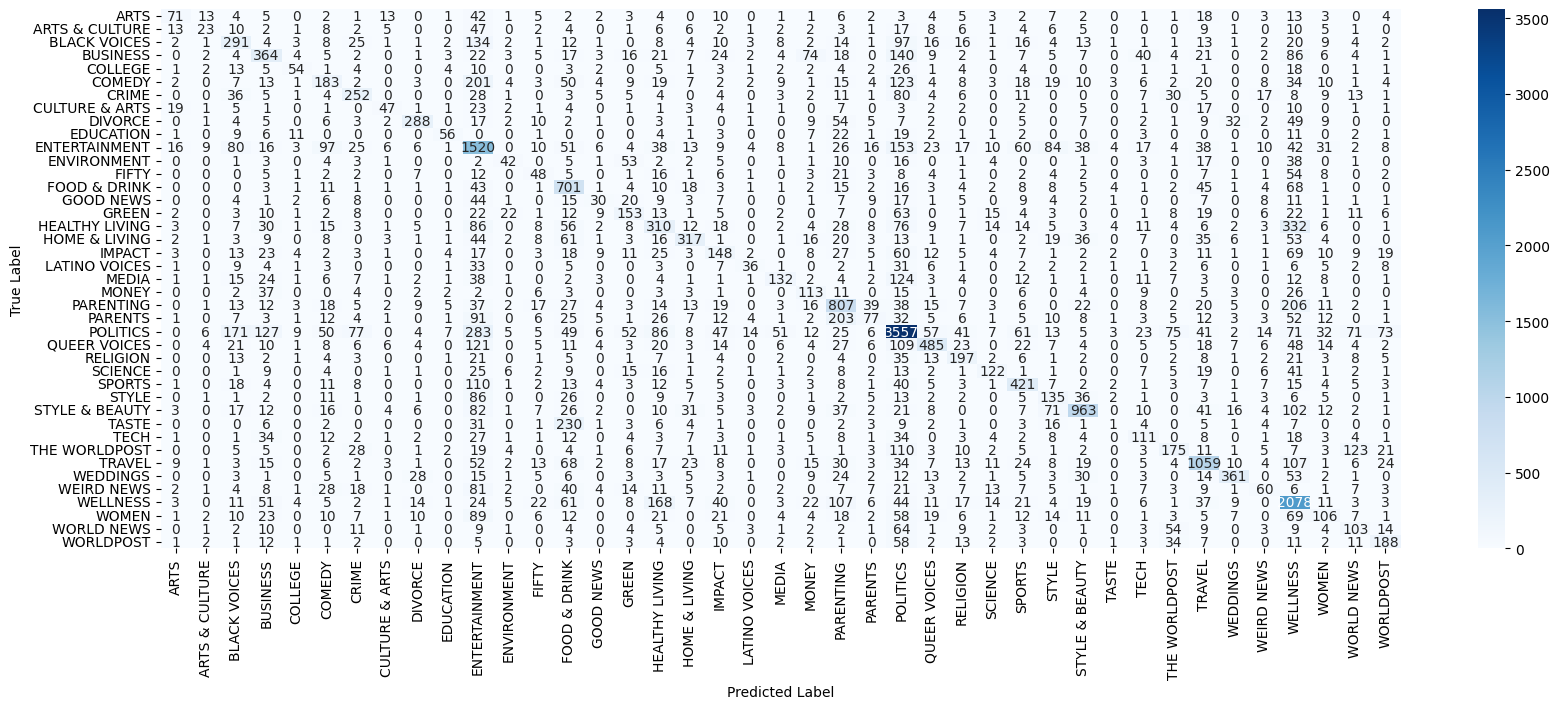

In [47]:

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(20, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()